In [ ]:
from pathlib import Path

import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image

from ssd import SSD
from ssd.data import LetterboxTransform

In [ ]:
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 300

In [ ]:
device = torch.device("cpu")
model = SSD.load(
    Path("/mnt/data/code/ssd/models/23ac32e7-5881-4f99-87a5-3b556464f721/best.pt"),
    device,
)

images_dir = Path("/mnt/data/datasets/object_detection/coco/images/val2017")
image_files = list(images_dir.glob("*.jpg"))

transform = LetterboxTransform()

In [ ]:
file_idx = 4
file = image_files[file_idx]

# Letterbox image
image = pil_to_tensor(Image.open(file))
letterbox_image = transform.transform_image(image, device)
image = letterbox_image.permute((1, 2, 0)).numpy().astype(np.uint8).copy()

# Run inference on the image
detections = model.infer(file=file, confidence_threshold=0.5, num_top_k=400, nms_iou_threshold=0.3)
for detection, score, label in zip(detections.boxes, detections.scores, detections.class_ids):
    cx, cy, w, h = detection
    left = int((cx - w/2) * IMAGE_WIDTH)
    right = int((cx + w/2) * IMAGE_WIDTH)
    top = int((cy - h/2) * IMAGE_HEIGHT)
    bottom = int((cy + h/2) * IMAGE_HEIGHT)

    image = cv2.rectangle(image, (left, top), (right, bottom), (255, 0, 0), 2)
    image = cv2.putText(image, f"C={int(label.item())} S={score.item():.3f}", (left, top - 4), 0, 0.3, (255, 0, 0), 1)
    print(f"Score: {score.item()} Label: {label.item()}")

plt.imshow(image)

In [63]:
from pathlib import Path

import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torch import Tensor
from torchvision.transforms.functional import pil_to_tensor
from torchvision.ops import box_convert
from torchvision.tv_tensors import BoundingBoxes, Image as TVImage

from ssd.data import DataAugmenter, LetterboxTransform, SSDDataset

In [64]:
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 300

DTYPE = torch.float32
DEVICE = torch.device("cpu")

In [65]:
image_file = Path("/mnt/data/datasets/object_detection/coco/images/train2017/000000484814.jpg")
image = Image.open(image_file)
image_tensor = pil_to_tensor(image)

label_file = Path("/mnt/data/datasets/object_detection/coco/labels/train2017/000000484814.txt")
objects = SSDDataset.read_label_file(label_file, DEVICE, DTYPE)

transform = LetterboxTransform(IMAGE_WIDTH, IMAGE_HEIGHT)
image_tensor, objects = transform(image_tensor, objects, DEVICE)

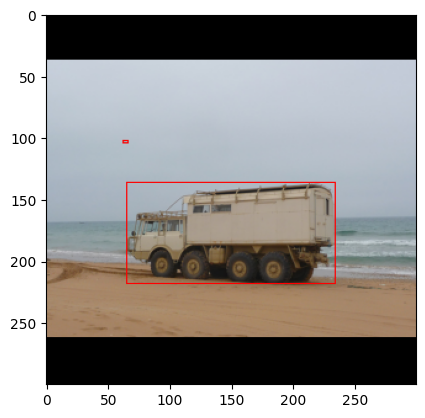

In [66]:
im = image_tensor.permute((1, 2, 0)).to(torch.uint8).cpu().numpy().copy()

boxes = box_convert(objects.boxes, "cxcywh", "xyxy") * 300
for idx in range(objects.boxes.shape[0]):
    p1 = tuple(boxes[idx, :2].to(torch.int).cpu().tolist())
    p2 = tuple(boxes[idx, 2:].to(torch.int).cpu().tolist())
    im = cv2.rectangle(im, p1, p2, (255, 0, 0), 1)

plt.imshow(im)

In [67]:
augmenter = DataAugmenter(IMAGE_WIDTH, IMAGE_HEIGHT)

boxes = objects.boxes.clone()
boxes[:, ::2] *= IMAGE_WIDTH
boxes[:, 1::2] *= IMAGE_HEIGHT
tv_boxes = BoundingBoxes(boxes, format="CXCYWH", canvas_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

trans_image: Tensor
trans_boxes: BoundingBoxes
trans_image, trans_boxes = augmenter(image_tensor, tv_boxes)

In [68]:
trans_boxes

BoundingBoxes([[186.9957, 113.5396, 226.0087, 149.5910],
               [300.0000,   0.0000,   0.0000,   0.0000]], format=BoundingBoxFormat.CXCYWH, canvas_size=(300, 300))

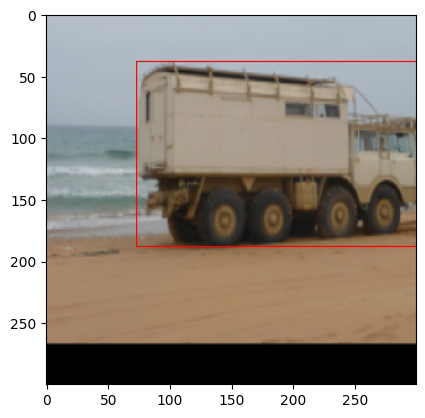

In [72]:
im = trans_image.permute((1, 2, 0)).to(torch.uint8).cpu().numpy().copy()

boxes = box_convert(trans_boxes, "cxcywh", "xyxy")
boxes = boxes[(boxes[:, 2] > 2).bitwise_and(boxes[:, 3] > 2), :]
for idx in range(boxes.shape[0]):
    p1 = tuple(boxes[idx, :2].to(torch.int).cpu().tolist())
    p2 = tuple(boxes[idx, 2:].to(torch.int).cpu().tolist())
    im = cv2.rectangle(im, p1, p2, (255, 0, 0), 1)

plt.imshow(im)

In [74]:
boxes

tensor([[ 73.9913,  38.7441, 300.0000, 188.3351]])